In [ ]:
import pandas as pd
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
# from em_algorithm import em_algorithm
from scipy.stats import multivariate_normal

## EMM + Tissue Models

### Loading Tissue Models 

In [ ]:
tissue_model_df = pd.read_csv('TissueModel.csv')

### Utility Functions

In [98]:
def readNiftiImage(file_path):
        # Read Nifti image
        try:
            niftiImage = nib.load(file_path).get_fdata()
            return niftiImage, nib.load(file_path).affine
        except Exception as e:
            print(f"Error reading NIFTI image from {file_path}: {str(e)}")           


def get_file_paths(folder_path):
    file_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".nii.gz"):
                file_paths.append(os.path.join(root, file))
    return sorted(file_paths)

# Evaluation

def calculate_dice_scores(pred, gt, labels=[1, 2, 3]):
        dice_scores = {}
        for label in labels:
            pred_count = np.sum(pred == label)
            gt_count = np.sum(gt == label)
            intersection = np.sum((pred == label) & (gt == label))
            if pred_count + gt_count == 0:
                dice_score = 1.0  # Perfect match if label is absent in both
            else:
                dice_score = 2 * intersection / (pred_count + gt_count)
            dice_scores[label] = dice_score
        return dice_scores
    
# Function to create a color-coded boxplot of Dice scores without black background
def plot_dice_score_boxplot(metrics_df):

    # Reshape the data for Seaborn
    melted_df = metrics_df.melt(id_vars=['Image'], value_vars=['CSF', 'WM', 'GM'],
                                        var_name='Tissue', value_name='Dice Score')

    # Define softer colors for each tissue type
    tissue_palette = {'CSF': '#a8dadc', 'WM': '#457b9d', 'GM': '#1d3557'}

    # Plot with Seaborn
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=melted_df, x='Tissue', y='Dice Score', palette=tissue_palette)
    plt.title("Dice Score Distribution for CSF, WM, and GM Using Tissue Models")
    plt.ylabel("Dice Score")
    plt.xlabel("Tissue Type")

    # Add legend
    legend_handles = [mpatches.Patch(color=color, label=tissue) for tissue, color in tissue_palette.items()]
    plt.legend(handles=legend_handles, title="Tissue Types")

    plt.show()
    
def normalize_image(vec, new_min=0, new_max=255):
        min_val = np.min(vec)
        max_val = np.max(vec)
        normalized_vec = (vec - min_val) / (max_val - min_val) * (new_max - new_min) + new_min
        return normalized_vec.astype(np.uint8)

### Data processing for EM

In [99]:
def em_preprocessing(image_data, mask_data):
    """
    Normalize an image and extract data based on a ground truth mask.

    Args:
        image_data (numpy.ndarray): Input image data.
        mask_data (numpy.ndarray): Ground truth mask data.

    Returns:
        numpy.ndarray: Extracted and normalized data from the image where the mask is greater than 0.
    """
    # Check for dimensional alignment
    if image_data.shape != mask_data.shape:
        raise ValueError(f"Image and mask dimensions do not match: {image_data.shape} vs {mask_data.shape}")

    # Normalize the image
    # normalized_image_data = (image_data - np.mean(image_data)) / np.std(image_data)

    # Extract data where mask is greater than 0
    extracted_data = image_data[mask_data > 0]

    # Validate that data has been extracted
    if extracted_data.size == 0:
        raise ValueError("No data was extracted. Check the mask for valid regions.")

    return extracted_data.reshape(-1, 1)  # Return as a column vector

def em_post_processing(data_1d, gt_data, mu_em, responsibilities, label_order=(1, 3, 2), num_classes=3):
    """
    Post-process the results of the EM algorithm to map labels consistently and reconstruct a 3D label map.

    Args:
        data_1d (numpy.ndarray): 1D array of data used in the EM algorithm.
        gt_data (numpy.ndarray): Ground truth mask used for extracting valid regions.
        mu_em (numpy.ndarray): Mean values for each cluster from the EM algorithm.
        responsibilities (numpy.ndarray): Responsibilities matrix from the EM algorithm.
        label_order (list or None): Desired order of labels (e.g., [1, 2, 3]). Defaults to ascending order.
        num_classes (int): Number of clusters (default: 3).

    Returns:
        numpy.ndarray: 3D label map with consistent labels.
    """
    # Set default label order to ascending order (1, 2, 3, ...)
    if label_order is None:
        label_order = list(range(1, num_classes + 1))  # Default to [1, 2, ..., num_classes]

    # Ensure mu_em is a 2D array
    if mu_em.ndim == 1:
        mu_em = mu_em.reshape(-1, 1)

    # Assign labels based on maximum responsibility
    labels = np.argmax(responsibilities, axis=1)

    # Create a mapping based on the specified label order
    sorted_indices = np.argsort(mu_em[:, 0])  # Sort by mean intensities
    label_mapping = {sorted_indices[i]: label_order[i] for i in range(num_classes)}  # Use provided label order

    # Map the labels to consistent labels
    mapped_labels = np.array([label_mapping.get(label, 0) for label in labels])  # Handle unmapped labels

    # Create a 3D label map initialized to zero
    label3d = np.zeros_like(gt_data)

    # Assign the mapped labels to the corresponding locations in the 3D label map
    label3d[gt_data > 0] = mapped_labels

    return label3d


### EM Algorithm

In [100]:
# Function to calculate the Gaussian probability
def gaussian_pdf(x, mu, cov):
    return multivariate_normal.pdf(x, mean=mu, cov=cov)


def em_algorithm(data, mu, sigma, pi, max_iter=100, tol=1e-6):
    """
    EM algorithm for Gaussian Mixture Models.
    Args:
        data (numpy.ndarray): Input data (n_samples, n_features).
        mu (numpy.ndarray): Initial means for clusters (n_clusters, n_features).
        sigma (numpy.ndarray): Initial standard deviations for clusters (n_clusters, n_features).
        pi (numpy.ndarray): Initial mixing coefficients (n_clusters,).
        max_iter (int): Maximum number of iterations.
        tol (float): Convergence tolerance.

    Returns:
        tuple: Updated mu, sigma, pi, log_likelihoods, responsibilities.
    """
    n_samples, n_features = data.shape
    n_clusters = mu.shape[0]

    # Validate parameters
    if not isinstance(n_clusters, int):
        raise ValueError(f"n_clusters must be an integer, but got {type(n_clusters)} with value {n_clusters}.")

    print(f"Running EM with n_clusters={n_clusters}, mu={mu}, sigma={sigma}, pi={pi}")

    # Initialize responsibilities (E-step)
    responsibilities = np.zeros((n_samples, n_clusters))
    log_likelihoods = []

    for iter in range(max_iter):
        ### E-Step: Compute responsibilities
        for i in range(n_clusters):
            responsibilities[:, i] = pi[i] * gaussian_pdf(data, mu[i], np.diag(sigma[i]**2))

        # Normalize responsibilities
        responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)

        ### M-Step: Update parameters
        N_k = responsibilities.sum(axis=0)

        # Update mu (means)
        for i in range(n_clusters):
            mu[i] = (responsibilities[:, i].reshape(-1, 1) * data).sum(axis=0) / N_k[i]

        # Update sigma (standard deviations)
        for i in range(n_clusters):
            diff = data - mu[i]
            sigma[i] = np.sqrt((responsibilities[:, i].reshape(-1, 1) * diff**2).sum(axis=0) / N_k[i])

        # Update pi (mixing coefficients)
        pi = N_k / n_samples

        ### Log-Likelihood Calculation
        log_likelihood = np.sum(np.log(np.sum([pi[k] * gaussian_pdf(data, mu[k], np.diag(sigma[k]**2))
                                               for k in range(n_clusters)], axis=0)))
        log_likelihoods.append(log_likelihood)

        # Check for convergence
        if iter > 0 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            print(f"Converged at iteration {iter}")
            break

    return mu, sigma, pi, log_likelihoods, responsibilities

In [ ]:
# def compute_mu_sigma_pi_from_tissue_model(tissue_model):
#     """
#     Compute mu (mean), sigma (standard deviation), and pi (probabilities) from a tissue model CSV.
    
#     Args:
#         csv_path (str): Path to the tissue model CSV.
    
#     Returns:
#         tuple: Arrays of mu (means), sigma (standard deviations), and pi (cluster probabilities) for each tissue type.
#     """
   
#     # Get the intensity indices (assuming they are row indices starting from 0)
#     intensities = np.arange(len(tissue_model)) + 1
    
#     mu = []
#     sigma = []
#     pi = []
    
#     # Iterate over each tissue type (columns)
#     for tissue_type in tissue_model.columns:
#         probabilities = tissue_model[tissue_type].values  # Get probabilities for the tissue type
        
#         # Weighted mean
#         mean = np.sum(probabilities * intensities) / np.sum(probabilities)
        
#         # Weighted standard deviation
#         variance = np.sum(probabilities * (intensities - mean) ** 2) / np.sum(probabilities)
#         std_dev = np.sqrt(variance)
        
#         # Total probability for this tissue type
#         probability = np.sum(probabilities) / np.sum(tissue_model.values)
        
#         mu.append(mean)
#         sigma.append(std_dev)
#         pi.append(probability)
    
#     return np.array(mu), np.array(sigma), np.array(pi)

In [ ]:
# def normalize_image(image, new_min=1, new_max=255):
#     """
#     Normalize the image intensities to a specified range.
    
#     Args:
#         image (numpy.ndarray): Original image array.
#         new_min (int): New minimum value for normalization (default: 1).
#         new_max (int): New maximum value for normalization (default: 255).
    
#     Returns:
#         numpy.ndarray: Normalized image in the specified range.
#     """
#     min_val = np.min(image)
#     max_val = np.max(image)
#     normalized_image = (image - min_val) / (max_val - min_val) * (new_max - new_min) + new_min
#     return normalized_image.astype(np.uint8)

# def compute_mu_sigma_pi_hard_labels(image, tissue_model):
#     """
#     Compute mu (mean), sigma (standard deviation), and pi (cluster probabilities) using hard-labeled intensities.

#     Args:
#         image (numpy.ndarray): 3D image array with normalized voxel intensities in range 1-255.
#         tissue_model (pd.DataFrame): Tissue model loaded from a CSV with probabilities for each tissue type.

#     Returns:
#         tuple: Arrays of mu (means), sigma (standard deviations), and pi (cluster probabilities) for each tissue type.
#     """
#     # Ensure tissue_model has 255 rows corresponding to intensities 1-255
#     if len(tissue_model) != 255:
#         raise ValueError("Tissue model must have exactly 255 rows, corresponding to intensities 1-255.")
    
#     # Convert tissue model to NumPy array for easy computation
#     tissue_probabilities = tissue_model.values  # Shape: (255, num_tissues)
    
#     # Find the label with the highest probability for each intensity
#     label_map = np.argmax(tissue_probabilities, axis=1) + 1  # Labels start from 1

#     # Map intensities to labels
#     intensities = image.flatten().astype(np.uint8)  # Flattened for easy processing
#     labels = np.zeros_like(intensities, dtype=np.uint8)

#     # Assign hard labels based on the intensity
#     labels[intensities > 0] = label_map[intensities[intensities > 0] - 1]

#     # Compute mu, sigma, and pi for each label
#     mu = []
#     sigma = []
#     pi = []
#     total_voxels = np.sum(labels > 0)  # Total number of non-background voxels

#     for label in range(1, tissue_probabilities.shape[1] + 1):
#         # Get all intensities assigned to the current label
#         label_intensities = intensities[labels == label]
        
#         if len(label_intensities) > 0:
#             # Compute mean and standard deviation
#             mu.append(np.mean(label_intensities))
#             sigma.append(np.std(label_intensities))
#             # Compute pi (proportion of voxels in this cluster)
#             pi.append(len(label_intensities) / total_voxels)
#         else:
#             # Handle empty clusters
#             mu.append(0)
#             sigma.append(0)
#             pi.append(0)

#     return np.array(mu), np.array(sigma), np.array(pi)

### Sample Execution of EM with TM initialization

In [ ]:
# Step-1: Load the image and mask data and preprocess the data

# open an image
image_path = 'test_set/testing-images/1019.nii.gz'
mask_path = 'test_set/testing-labels/1019_3C.nii.gz'

image, _ = readNiftiImage(image_path)
mask, _ = readNiftiImage(mask_path)

# normalize the image removing the background

image = np.where(mask > 0, image, 0)
masked_image = image[mask > 0]
image[mask > 0] = normalize_image(masked_image)

# Load and preprocess the image data
data = em_preprocessing(image, mask)

In [ ]:
# plot the normalized image
plt.figure(figsize=(8, 8))
plt.imshow(image[:, :, 100], cmap='gray')

# plot the histogram of the normalized image
plt.figure(figsize=(8, 6))
plt.hist(image[mask > 0], bins=255, color='skyblue', edgecolor='black')

In [ ]:
# plot histogram of data
plt.figure(figsize=(8, 6))
plt.hist(data, bins=255, color='skyblue', edgecolor='black')

In [ ]:
# Step-2 : Use tissue model to get the initial responsabilities for the EM algorithm
tissue_model = tissue_model_df[['CSF', 'WM', 'GM']]
tissue_model = tissue_model.to_numpy()

# map the tissue model probabilities to the intensities to get the initial responsabilities
responsibilities = np.zeros((*data.shape, 3))  # Include all spatial dimensions and 3 for CSF, WM, GM

# Assign tissue model probabilities to the respective voxels
for i in range(1, 256):
    responsibilities[data == i, :] = tissue_model[i - 1]

In [ ]:
# responsibilities.shape

# Assuming `responsabilities` has the shape (1172736, 1, 3)
responsibilities = np.squeeze(responsibilities, axis=1)

# responsibilities.shape

In [ ]:
responsibilities

In [ ]:
# Step-3 Calculate the initial parameters for the EM algorithm

n_clusters = 3
n_samples = data.shape[0]
mu_init = np.zeros((n_clusters, 1))
sigma_init = np.zeros((n_clusters, 1))

### M-Step: Update parameters
N_k = responsibilities.sum(axis=0)

# Update mu (means)
for i in range(n_clusters):
    mu_init[i] = (responsibilities[:, i].reshape(-1, 1) * data).sum(axis=0) / N_k[i]

# Update sigma (standard deviations)
for i in range(n_clusters):
    diff = data - mu_init[i]
    sigma_init[i] = np.sqrt((responsibilities[:, i].reshape(-1, 1) * diff**2).sum(axis=0) / N_k[i])

    # Update pi (mixing coefficients)
    pi_init = N_k / n_samples
    
mu_init, sigma_init, pi_init

In [ ]:
# Step-4: Run the EM algorithm

mu, sigma, pi, log_likelihoods, responsibilities = em_algorithm(data, mu_init, sigma_init, pi_init max_iter=100, tol=1e-6)

In [ ]:
# Step-5: Post-process the results

label3d = em_post_processing(data, mask, mu, responsibilities, num_classes=3)

# Calculate Dice scores

metrics = {'Image': [], 'CSF': [], 'WM': [], 'GM': []}

# Compute Dice scores
dice_scores = calculate_dice_scores(label3d, mask, labels=[1, 2, 3])
metrics['Image'].append(f'Image_{i+1}')
metrics['CSF'].append(dice_scores[1])
metrics['WM'].append(dice_scores[2])
metrics['GM'].append(dice_scores[3])

print(f"Dice scores for Image_{i+1}: CSF={dice_scores[1]:.4f}, WM={dice_scores[2]:.4f}, GM={dice_scores[3]:.4f}")


In [102]:
# Repeat the five steps for all the images in the test set

# Get the file paths for the images and masks
image_paths = get_file_paths('test_set\\testing-images')
mask_paths = get_file_paths('test_set\\testing-labels')
tissue_model_df = pd.read_csv('TissueModel.csv')
tissue_model = tissue_model_df[['CSF', 'WM', 'GM']]
tissue_model = tissue_model.to_numpy()

# Initialize a metrics dictionary to store Dice scores
metrics = {'Image': [], 'CSF': [], 'WM': [], 'GM': []}

# Tissue model for initialization
tissue_model_df = pd.read_csv('TissueModel.csv')
tissue_model = tissue_model_df[['CSF', 'WM', 'GM']].to_numpy()

# Loop through each image and mask
for image_file, mask_file in zip(image_paths, mask_paths):
    print(f"Processing {image_file} and {mask_file}...")

    # Step 1: Load and preprocess the image and mask
    image, _ = readNiftiImage(image_file)
    mask, _ = readNiftiImage(mask_file)

    # Normalize the image while removing the background
    image = np.where(mask > 0, image, 0)
    masked_image = image[mask > 0]
    image[mask > 0] = normalize_image(masked_image)

    # Prepare data for EM
    data = em_preprocessing(image, mask)

    # Debugging check
    print(f"Unique values in data for {image_file}: {np.unique(data)}")

    # Step 2: Initialize responsibilities using the tissue model
    responsibilities = np.zeros((*data.shape, 3))
    for i in range(1, 256):
        responsibilities[data == i, :] = tissue_model[i - 1]
    responsibilities = np.squeeze(responsibilities, axis=1)

    # Step 3: Calculate initial parameters for the EM algorithm
    n_clusters = 3
    n_samples = data.shape[0]
    mu_init = np.zeros((n_clusters, 1))
    sigma_init = np.zeros((n_clusters, 1))
    N_k = responsibilities.sum(axis=0)

    for i in range(n_clusters):
        mu_init[i] = (responsibilities[:, i].reshape(-1, 1) * data).sum(axis=0) / N_k[i]
        diff = data - mu_init[i]
        sigma_init[i] = np.sqrt((responsibilities[:, i].reshape(-1, 1) * diff**2).sum(axis=0) / N_k[i])
    pi_init = N_k / n_samples

    # Debugging initial parameters
    print(f"Initial mu for {image_file}: {mu_init.flatten()}")
    print(f"Initial sigma for {image_file}: {sigma_init.flatten()}")

    # Step 4: Run the EM algorithm
    mu, sigma, pi, log_likelihoods, responsibilities = em_algorithm(
        data, mu_init, sigma_init, pi_init, max_iter=100, tol=1e-6
    )

    # Debugging EM results
    print(f"Final mu for {image_file}: {mu.flatten()}")

    # Step 5: Post-process the results
    label3d = em_post_processing(data, mask, mu, responsibilities, num_classes=3)

    # Calculate Dice scores
    dice_scores = calculate_dice_scores(label3d, mask, labels=[1, 2, 3])
    metrics['Image'].append(image_file)
    metrics['CSF'].append(dice_scores[1])
    metrics['WM'].append(dice_scores[2])
    metrics['GM'].append(dice_scores[3])

    print(f"Dice scores for {image_file}: CSF={dice_scores[1]:.4f}, WM={dice_scores[2]:.4f}, GM={dice_scores[3]:.4f}")


Processing test_set\testing-images\1003.nii.gz and test_set\testing-labels\1003_3C.nii.gz...
Unique values in data for test_set\testing-images\1003.nii.gz: [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 16



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



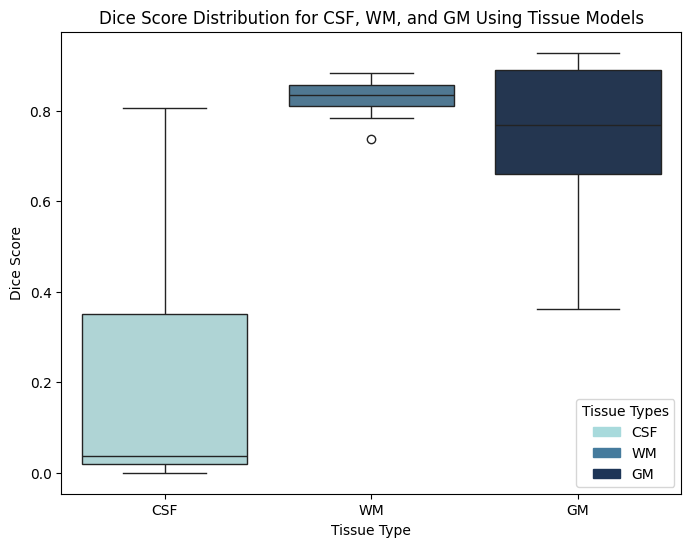

In [104]:
# Convert the metrics dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the Dice score boxplot
plot_dice_score_boxplot(metrics_df)

# Save the metrics DataFrame to a CSV file
metrics_df.to_csv('Result\\EM+TM\\em_tm_dice_scores.csv', index=False)

In [ ]:
# # Load the test set images and masks
# test_image_files = get_file_paths("test_set\\testing-images")
# test_mask_files = get_file_paths("test_set\\testing-labels")

# # Use a dataframe to store the results for each image
# results = []

# # Loop over each image and mask
# for image_path, mask_path in zip(test_image_files, test_mask_files):
#     print(f"Processing image: {image_path}")
    
#     try:
#         # Load and preprocess the image and mask
#         image, _ = readNiftiImage(image_path)
#         gt_mask, _ = readNiftiImage(mask_path)
        
#         data = em_preprocessing(image, gt_mask)
        
#         # Initialize clusters
#         mu, sigma, pi = initialize_clusters(image, init_type='tissue_model', tissue_model=tissue_models)
        
#         print(data.ndim)
        
#         # Apply the EM algorithm
#         mu_em, sigma_em, pi_em, responsibilities = em_algorithm(data, mu, sigma, pi)
        
#         # Post-process the results
#         label3d = em_post_processing(data, responsibilities, mu_em)
        
#         # Ensure dimensions match for Dice score calculation
#         if label3d.shape != gt_mask.shape:
#             raise ValueError("Prediction and ground truth masks have mismatched dimensions.")
        
#         # Calculate Dice scores
#         dice_scores = calculate_dice_scores(label3d, gt_mask, labels=[1, 2, 3])
        
#         # Append the results
#         results.append({
#             'Image': os.path.basename(image_path),
#             'CSF': dice_scores[1],
#             'WM': dice_scores[2],
#             'GM': dice_scores[3]
#         })
    
#     except Exception as e:
#         print(f"Error processing image {image_path}: {e}")

# # Convert results to a DataFrame
# results_df = pd.DataFrame(results)